# 0. 패키지 및 데이터 불러오기

In [4]:
!pip install FRUFS
!pip install catboost
!pip install pandas
!pip install numpy
!pip install lightgbm
!pip install category_encoders
!pip install optuna
!pip install seaborn
!pip install matplot
!pip install imblearn
!pip install pacmap
!pip install missingpy


In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.inspection import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.svm import *

from FRUFS import *
# from missingpy import MissForest

import math
from scipy.stats import ranksums
from statsmodels.formula.api import ols
from lightgbm import *
from catboost import *

import warnings
warnings.filterwarnings(action = 'ignore') # 경고메세지를 무시하거나 숨긴다.

In [6]:
# 경로 확인2
!ls '/home/studio-lab-user/MYDATA/Construction Machine Oil/open/'

data_info.xlsx	sample_submission.csv  test.csv  train.csv


In [7]:
path = '/home/studio-lab-user/MYDATA/Construction Machine Oil/open/'

Rdata_train = pd.read_csv(path + 'train.csv')
Rdata_test = pd.read_csv(path + 'test.csv')

print(Rdata_train.shape) # (14095, 54) -> 생각보다 데이터 수가 적다.
print(Rdata_train.size)
print(Rdata_test.shape) # (6041, 19)
print(Rdata_test.size)
Rdata_train.head()

(14095, 54)
761130
(6041, 19)
114779


,ID,COMPONENT_ARBITRARY,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,...,U25,U20,U14,U6,U4,V,V100,V40,ZN,Y_LABEL
0,TRAIN_00000,COMPONENT3,1486,2011,7,200,0,3,93,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,154.0,75,0
1,TRAIN_00001,COMPONENT2,1350,2021,51,375,0,2,19,0,...,2.0,4.0,6.0,216.0,1454.0,0,NaN,44.0,652,0
2,TRAIN_00002,COMPONENT2,2415,2015,2,200,0,110,1,1,...,0.0,3.0,39.0,11261.0,41081.0,0,NaN,72.6,412,1
3,TRAIN_00003,COMPONENT3,7389,2010,2,200,0,8,3,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.3,7,0
4,TRAIN_00004,COMPONENT3,3954,2015,4,200,0,1,157,0,...,NaN,NaN,NaN,NaN,NaN,0,NaN,133.1,128,0


In [8]:
Rdata_train.notnull().sum(axis = 0)

ID                     14095
COMPONENT_ARBITRARY    14095
ANONYMOUS_1            14095
YEAR                   14095
SAMPLE_TRANSFER_DAY    14095
ANONYMOUS_2            14095
AG                     14095
AL                     14095
B                      14095
BA                     14095
BE                     14095
CA                     14095
CD                     12701
CO                     14095
CR                     14095
CU                     14095
FH2O                    3890
FNOX                    3890
FOPTIMETHGLY            3890
FOXID                   3890
FSO4                    3890
FTBN                    3890
FE                     14095
FUEL                    3890
H2O                    14095
K                      11796
LI                     14095
MG                     14095
MN                     14095
MO                     14095
NA                     14095
NI                     14095
P                      14095
PB                     14095
PQINDEX       

In [9]:
notnull_columns = Rdata_train.loc[:, Rdata_train.notnull().sum(axis = 0) == 14095].columns
notnull_columns = notnull_columns[1 :]
notnull_columns = list(notnull_columns)

select_columns = notnull_columns[: 32] + ['K', 'CD'] + notnull_columns[33 :]

In [10]:
Rdata_train2 = Rdata_train.loc[:, select_columns]
Rdata_train2.shape

(14095, 35)

In [11]:
Rdata_train2.columns

Index(['COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR', 'SAMPLE_TRANSFER_DAY',
       'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CO', 'CR', 'CU',
       'FE', 'H2O', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX',
       'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'K', 'CD', 'Y_LABEL'],
      dtype='object')

1. COMPONENT_ARBITRARY : 샘플 오일 관련 부품 (Component 4종, 비식별화) : 명목형
2. ANONYMOUS_1 : 무명 Feautre 1. 수치형 데이터
3. YEAR : 오일 샘플 및 진단 해 (Year)
4. SAMPLE_TRANSFER_DAY : 오일 샘플링 후 진단 기관으로 이동한 기간 (Days)
5. ANONYMOUS_2 : 무명 Feautre 2. 수치형 데이터
6. AG : 원소기호 AG - Silver 함유량
7. AL : 원소기호 AL - Aluminium 함유량
8. B : 원소기호 B - Boron 함유량
9. BA : 원소기호 BA -  Barium 함유량
10. BE : 원소기호 BE - Beryllium 함유량
11. CA : 원소기호 CA - Calcium 함유량
12. CD : 원소기호 CD - Cadmium 함유량
13. CO : 원소기호 CO - Cobolt 함유량
14. CR : 원소기호 CR - Chromium 함유량
15. CU : 원소기호 CU - Copper 함유량
16. FH2O : Water 수치(By FT-IR)
17. FNOX : NOx 수치(By FT-IR)
18. FOPTIMETHGLY : 비식별화
19. FOXID : Oxidation 수치(By FT-IR)
20. FSO4 : SO4 수치(By FT-IR)
21. FTBN : 염기성 첨가제물질 수치(By FT-IR)
22. FE : 원소기호 FE - Iron 함유량
23. FUEL : 연료 함유량
24. H2O : Water 함유량
25. K : 원소기호 K - Potassium 함유량
26. LI : 원소기호 LI - Lithium 함유량
27. MG : 원소기호 MG - Magnesium 함유량
28. MN : 원소기호 MN - Manganese 함유량
29. MO : 원소기호 MO - Molybdenum 함유량
30. NA : 원소기호 NA - Sodium 함유량
31. NI : 원소기호 NI - Nickel 함유량
32. P : 원소기호 P - Phosphorus 함유량
33. PB : 원소기호 PB - Lead 함유량
34. PQINDEX : Particle Quantifier Index
35. S : 원소기호 S - Sulphur 함유량
36. SB : 원소기호 SB - Antimony 함유량
37. SI : 원소기호 SI - Silicone 함유량
38. SN : 원소기호 SN - Tin 함유량
39. SOOTPERCENTAGE : Soot 함유량(%)
40. TI : 원소기호 TI - Titanium 함유량
41. U100 : Particle Count (100㎛ 이상 크기 입자)
42. U75 : Particle Count (75㎛ 이상 크기 입자)
43. U50 : Particle Count (50㎛ 이상 크기 입자)
44. U25 : Particle Count (25㎛ 이상 크기 입자)
45. U20 : Particle Count (20㎛ 이상 크기 입자)
46. U14 : Particle Count (14㎛ 이상 크기 입자)
47. U6 : Particle Count (6㎛ 이상 크기 입자)
48. U4 : Particle Count (4㎛ 이상 크기 입자)
49. V : 원소기호 V - Vanadium 함유량
50. V100 : Viscosity @ 100 degrees
51. V40 : Viscosity @ 40 degrees
52. ZN : 원소기호 ZN - Zinc 함유량
53. Y_LABEL : 오일 정상 여부 (0 : 정상, 1 : 이상)

# 1. 변수별 상관계수

정수형, 연속형, 날짜형만 사용하여 상관관계를 확인해본다.

In [12]:
# A 변수 끼리 상관관계

t = Rdata_train2.copy()
corr = t.corr()
corr.style.background_gradient(cmap = 'coolwarm')

# TI와 V : 0.678
# FE와 SI : 0.649
# NI와 SI : 0.630
# FE와 MN : 0.622
# S와 V40 : 0.607
# SI와 TI : 0.606
# SI와 K : 0.605
# MN와 TI : 0.585
# FE와 NI : 0.583
# MN와 SI : 0.554
# CO와 FE : 0.537
# MN와 NI : 0.583
# TI와 K : 0.524
# MN와 K : 0.511


,ANONYMOUS_1,YEAR,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CO,CR,CU,FE,H2O,LI,MG,MN,MO,NA,NI,P,PB,PQINDEX,S,SB,SI,SN,TI,V,V40,K,CD,Y_LABEL
ANONYMOUS_1,1.000000,0.106546,-0.041395,0.072154,-0.025674,0.017924,0.013467,-0.064204,-0.010805,-0.015321,-0.003783,-0.007035,-0.014086,0.000440,0.003868,0.000944,-0.001807,-0.004212,-0.006206,0.000183,-0.007862,-0.013647,-0.000499,0.002277,0.016374,-0.011797,0.005141,-0.009564,0.001832,0.001883,0.019542,-0.004384,0.010076,0.044197
YEAR,0.106546,1.000000,-0.094086,0.138199,-0.129124,-0.017525,0.011145,-0.098589,-0.063859,0.090465,-0.052337,-0.028871,-0.137593,-0.057709,0.009855,0.002697,0.025616,-0.039132,-0.091482,0.028953,-0.049206,-0.143675,-0.031021,-0.067160,-0.141084,-0.019612,0.011831,-0.065335,0.006399,-0.027624,-0.051584,-0.032801,-0.012668,-0.087871
SAMPLE_TRANSFER_DAY,-0.041395,-0.094086,1.000000,-0.000060,0.021211,-0.017493,0.004305,0.016909,0.009600,0.008826,0.002195,-0.001495,0.006303,0.011651,-0.007926,-0.002275,0.008802,0.006816,0.001051,-0.006263,0.015599,-0.009730,0.000543,0.033622,0.014327,-0.015647,0.007713,0.006986,-0.002855,-0.002412,0.013896,0.012344,-0.006108,-0.004315
ANONYMOUS_2,0.072154,0.138199,-0.000060,1.000000,-0.006266,-0.022788,-0.100307,-0.011871,0.011162,-0.043046,-0.000070,-0.001826,-0.002244,-0.004608,-0.003760,-0.002483,-0.003306,0.003304,-0.008465,0.000647,-0.003914,0.000771,0.000519,-0.010409,-0.033153,0.006001,0.007633,0.004799,-0.000981,-0.006469,-0.025339,-0.003246,0.012702,-0.033641
AG,-0.025674,-0.129124,0.021211,-0.006266,1.000000,0.019600,-0.028131,0.031649,0.020884,-0.004489,0.008861,0.005397,0.051046,0.025959,-0.003850,0.002394,-0.009523,0.019507,0.013124,-0.007197,0.054014,0.024517,0.020716,0.030929,0.017271,0.028327,0.020739,0.016582,0.003609,-0.003853,0.013592,0.013082,0.004325,0.014671
AL,0.017924,-0.017525,-0.017493,-0.022788,0.019600,1.000000,0.000037,0.240863,-0.000858,-0.070322,0.009920,0.011430,0.037530,0.051138,-0.000093,0.000008,-0.001625,0.033695,-0.002615,-0.002290,0.099946,-0.022301,-0.004914,0.030492,0.011343,0.003998,0.087274,-0.006664,0.062613,0.026213,0.013823,0.037586,-0.004580,0.370512
B,0.013467,0.011145,0.004305,-0.100307,-0.028131,0.000037,1.000000,-0.045454,-0.013252,0.356121,0.005536,0.003759,0.000142,0.003075,-0.005442,0.015888,0.003456,0.000792,-0.001100,0.004937,0.010686,-0.004137,0.008009,-0.003177,0.005926,-0.019423,0.004165,-0.000990,0.008712,0.018197,-0.000882,-0.004724,-0.018408,-0.029787
BA,-0.064204,-0.098589,0.016909,-0.011871,0.031649,0.240863,-0.045454,1.000000,0.029900,-0.008642,0.004970,0.000443,0.023212,0.012627,-0.005055,-0.005337,-0.006470,0.007149,-0.004351,-0.004076,0.018465,0.003426,0.000497,0.003411,0.013244,0.006005,0.010588,0.004767,0.005074,0.000480,0.004150,0.007964,-0.001110,0.104840
BE,-0.010805,-0.063859,0.009600,0.011162,0.020884,-0.000858,-0.013252,0.029900,1.000000,0.006735,0.014084,0.002712,-0.001388,0.002707,-0.001610,-0.000977,0.045744,-0.000759,0.000208,-0.005445,0.001227,0.024291,0.006927,-0.000746,0.002929,0.007266,-0.002948,0.025744,-0.002501,0.000482,0.001359,0.003115,-0.002690,0.010685
CA,-0.015321,0.090465,0.008826,-0.043046,-0.004489,-0.070322,0.356121,-0.008642,0.006735,1.000000,0.001185,-0.015970,0.008900,-0.012488,-0.013057,-0.003960,0.023333,0.011866,-0.001413,0.014019,-0.003472,0.032399,0.022724,-0.003129,-0.078747,0.022265,-0.006390,-0.006153,-0.013781,-0.014419,-0.059102,-0.007404,-0.005770,-0.150379


In [13]:
abs(corr.loc['Y_LABEL', :]).sort_values(ascending = False)

Y_LABEL                1.000000
AL                     0.370512
CA                     0.150379
BA                     0.104840
YEAR                   0.087871
FE                     0.047992
NI                     0.046806
ANONYMOUS_1            0.044197
SI                     0.036731
ANONYMOUS_2            0.033641
B                      0.029787
PQINDEX                0.028966
S                      0.027923
TI                     0.025637
CU                     0.024975
MN                     0.024274
K                      0.023963
V40                    0.023195
V                      0.020862
AG                     0.014671
CR                     0.014233
NA                     0.010820
BE                     0.010685
MG                     0.008807
CO                     0.008175
P                      0.007602
CD                     0.005241
SAMPLE_TRANSFER_DAY    0.004315
H2O                    0.004262
PB                     0.003549
LI                     0.002921
SN      

# 2. 이상치 분석

In [87]:
# IQR Method에서 경계값을 나타낸 함수
def IQR_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR) 
    upper_bound = Q3 + (1.5 * IQR)

    return pd.concat([lower_bound, upper_bound], axis = 1).T

In [88]:
select_columns

['COMPONENT_ARBITRARY',
 'ANONYMOUS_1',
 'YEAR',
 'SAMPLE_TRANSFER_DAY',
 'ANONYMOUS_2',
 'AG',
 'AL',
 'B',
 'BA',
 'BE',
 'CA',
 'CO',
 'CR',
 'CU',
 'FE',
 'H2O',
 'LI',
 'MG',
 'MN',
 'MO',
 'NA',
 'NI',
 'P',
 'PB',
 'PQINDEX',
 'S',
 'SB',
 'SI',
 'SN',
 'TI',
 'V',
 'V40',
 'K',
 'CD',
 'Y_LABEL']

In [89]:
variable_32 = select_columns.copy()
variable_32.remove('COMPONENT_ARBITRARY')
variable_32.remove('YEAR')
variable_32.remove('Y_LABEL')
print(len(variable_32))
print(len(select_columns))

32
35


In [90]:
variable_32 = ['ANONYMOUS_1', 'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 
               'AG', 'AL', 'B', 'BA', 'BE', 'CA', 'CO', 'CR', 'CU', 'FE', 'H2O', 'LI', 'MG', 'MN', 
               'MO', 'NA', 'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V', 'V40', 'K', 'CD']

outlier_table = pd.DataFrame(np.zeros([8, len(variable_32)]), columns = variable_32,
                             index = ['정상 범위 데이터 개수', '이상 범위 데이터 개수', '전체 데이터 합계', 
                                      '정상 범위 데이터의 불량 개수', '이상 범위 데이터의 불량 개수', '불량 합계',
                                      '정상 범위 데이터의 불량률', '이상 범위 데이터의 불량률'])

for v in variable_32 :
  temp1 = Rdata_train2.loc[(IQR_outlier(Rdata_train2).loc[0, v] <= Rdata_train2[v]) & 
                        (Rdata_train2[v] <= IQR_outlier(Rdata_train2).loc[1, v]), :]
  temp2 = Rdata_train2.loc[(IQR_outlier(Rdata_train2).loc[0, v] > Rdata_train2[v]) | (Rdata_train2[v] > IQR_outlier(Rdata_train2).loc[1, v]), :]
  
  print(v)
  outlier_table.at['정상 범위 데이터 개수', v] = temp1.shape[0]
  outlier_table.at['이상 범위 데이터 개수', v] = temp2.shape[0]
  outlier_table.at['전체 데이터 합계', v] = temp1.shape[0] + temp2.shape[0]

  temp3 = temp1.loc[Rdata_train2['Y_LABEL'] == 1, :]
  temp4 = temp2.loc[Rdata_train2['Y_LABEL'] == 1, :]
  outlier_table.at['정상 범위 데이터의 불량 개수', v] = temp3.shape[0]
  outlier_table.at['이상 범위 데이터의 불량 개수', v] = temp4.shape[0]
  outlier_table.at['불량 합계', v] = temp3.shape[0] + temp4.shape[0]  

  if temp1.shape[0] == 0 :
    temp5 = 0
  else :
    temp5 = np.round(temp3.shape[0] / temp1.shape[0] * 100, 3)
  outlier_table.at['정상 범위 데이터의 불량률', v] = temp5 

  if temp2.shape[0] == 0 :
    temp6 = 0
  else :
    temp6 = np.round(temp4.shape[0] / temp2.shape[0] * 100, 3)    
  outlier_table.at['이상 범위 데이터의 불량률', v] = temp6

ANONYMOUS_1
SAMPLE_TRANSFER_DAY
ANONYMOUS_2
AG
AL
B
BA
BE
CA
CO
CR
CU
FE
H2O
LI
MG
MN
MO
NA
NI
P
PB
PQINDEX
S
SB
SI
SN
TI
V
V40
K
CD


In [91]:
outlier_table = outlier_table.T

In [92]:
# 이상 범위 데이터 개수가 많은 순 -> BA, NI, SB, MO, CU 순
outlier_table.nlargest(len(variable_32), columns = ['이상 범위 데이터 개수'])

# CA, S, BE는 이상 범위 데이터 수가 너무 작다.

,정상 범위 데이터 개수,이상 범위 데이터 개수,전체 데이터 합계,정상 범위 데이터의 불량 개수,이상 범위 데이터의 불량 개수,불량 합계,정상 범위 데이터의 불량률,이상 범위 데이터의 불량률
BA,10780.0,3315.0,14095.0,585.0,618.0,1203.0,5.427,18.643
NI,11024.0,3071.0,14095.0,843.0,360.0,1203.0,7.647,11.723
SB,11128.0,2967.0,14095.0,902.0,301.0,1203.0,8.106,10.145
MO,11473.0,2622.0,14095.0,984.0,219.0,1203.0,8.577,8.352
CU,11871.0,2224.0,14095.0,982.0,221.0,1203.0,8.272,9.937
PQINDEX,12022.0,2073.0,14095.0,968.0,235.0,1203.0,8.052,11.336
SI,12246.0,1849.0,14095.0,1004.0,199.0,1203.0,8.199,10.763
FE,12397.0,1698.0,14095.0,1003.0,200.0,1203.0,8.091,11.779
MN,12498.0,1597.0,14095.0,1025.0,178.0,1203.0,8.201,11.146
MG,12601.0,1494.0,14095.0,1070.0,133.0,1203.0,8.491,8.902


In [93]:
# 이상 범위 데이터의 불량 개수 많은 순 -> AL, BA, NI, SB, PQINDEX 순
outlier_table.nlargest(len(variable_32), columns = ['이상 범위 데이터의 불량 개수'])

,정상 범위 데이터 개수,이상 범위 데이터 개수,전체 데이터 합계,정상 범위 데이터의 불량 개수,이상 범위 데이터의 불량 개수,불량 합계,정상 범위 데이터의 불량률,이상 범위 데이터의 불량률
AL,12651.0,1444.0,14095.0,506.0,697.0,1203.0,4.000,48.269
BA,10780.0,3315.0,14095.0,585.0,618.0,1203.0,5.427,18.643
NI,11024.0,3071.0,14095.0,843.0,360.0,1203.0,7.647,11.723
SB,11128.0,2967.0,14095.0,902.0,301.0,1203.0,8.106,10.145
PQINDEX,12022.0,2073.0,14095.0,968.0,235.0,1203.0,8.052,11.336
CU,11871.0,2224.0,14095.0,982.0,221.0,1203.0,8.272,9.937
MO,11473.0,2622.0,14095.0,984.0,219.0,1203.0,8.577,8.352
FE,12397.0,1698.0,14095.0,1003.0,200.0,1203.0,8.091,11.779
SI,12246.0,1849.0,14095.0,1004.0,199.0,1203.0,8.199,10.763
MN,12498.0,1597.0,14095.0,1025.0,178.0,1203.0,8.201,11.146


In [94]:
# 이상 범위 데이터의 불량률 높은 순 -> AL, FOPTIMETHGLY, BA, FNOX, FOXID 순
outlier_table.nlargest(len(variable_32), columns = ['이상 범위 데이터의 불량률'])
# 이건 참고용으로만 -> 부정확하다.

,정상 범위 데이터 개수,이상 범위 데이터 개수,전체 데이터 합계,정상 범위 데이터의 불량 개수,이상 범위 데이터의 불량 개수,불량 합계,정상 범위 데이터의 불량률,이상 범위 데이터의 불량률
AL,12651.0,1444.0,14095.0,506.0,697.0,1203.0,4.000,48.269
BA,10780.0,3315.0,14095.0,585.0,618.0,1203.0,5.427,18.643
S,14088.0,7.0,14095.0,1202.0,1.0,1203.0,8.532,14.286
ANONYMOUS_1,13250.0,845.0,14095.0,1083.0,120.0,1203.0,8.174,14.201
V,13696.0,399.0,14095.0,1147.0,56.0,1203.0,8.375,14.035
CR,13070.0,1025.0,14095.0,1061.0,142.0,1203.0,8.118,13.854
K,10738.0,1058.0,11796.0,854.0,141.0,995.0,7.953,13.327
CO,13798.0,297.0,14095.0,1164.0,39.0,1203.0,8.436,13.131
H2O,13703.0,392.0,14095.0,1153.0,50.0,1203.0,8.414,12.755
CD,12543.0,158.0,12701.0,1019.0,19.0,1038.0,8.124,12.025


# 3. 불량 데이터의 중위수와 이상 범위 

In [26]:
variable = variable_32

target_var = []

for v in variable :
  
  print(v)

  LB = IQR_outlier(Rdata_train).loc[0, v]
  RB = IQR_outlier(Rdata_train).loc[1, v]
  Defect_Q50 = Rdata_train.loc[(Rdata_train['Y_LABEL'] == 1) & (Rdata_train[v].notnull()), v].quantile(0.5)
  
  print(LB, Defect_Q50, RB)

  if (Defect_Q50 < LB) or (Defect_Q50 > RB) :
    target_var.append(v)
  else :
    continue

ANONYMOUS_1
-1558.0 2790.0 7010.0
SAMPLE_TRANSFER_DAY
-4.5 5.0 15.5
ANONYMOUS_2
-115.0 200.0 725.0
AG
0.0 0.0 0.0
AL
-3.5 22.0 8.5
B
-157.5 8.0 270.5
BA
0.0 1.0 0.0
BE
0.0 0.0 0.0
CA
-4342.5 81.0 7365.5
CO
0.0 0.0 0.0
CR
-4.5 1.0 7.5
CU
-23.0 5.0 41.0
FE
-173.5 58.0 326.5
H2O
0.0 0.0 0.0
LI
0.0 0.0 0.0
MG
-14.5 5.0 29.5
MN
-3.0 1.0 5.0
MO
-10.5 1.0 17.5
NA
-6.0 2.0 10.0
NI
0.0 0.0 0.0
P
-531.5 919.0 2080.5
PB
-3.0 0.0 5.0
PQINDEX
-241.5 37.0 434.5
S
-18523.75 9422.0 42714.25
SB
0.0 0.0 0.0
SI
-10.5 7.0 25.5
SN
-1.5 0.0 2.5
TI
0.0 0.0 0.0
V
0.0 0.0 0.0
V40
-26.299999999999997 117.6 235.29999999999998
K
-4.5 2.0 7.5
CD
0.0 0.0 0.0


In [27]:
target_var # AL 은 사용이 가능하다면 어떻게든 test data에 만들어야 할 듯

['AL', 'BA']

# 4. 윌콕슨 순위합 검정

In [71]:
Rdata_train.columns

Index(['ID', 'COMPONENT_ARBITRARY', 'ANONYMOUS_1', 'YEAR',
       'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B', 'BA', 'BE', 'CA',
       'CD', 'CO', 'CR', 'CU', 'FH2O', 'FNOX', 'FOPTIMETHGLY', 'FOXID', 'FSO4',
       'FTBN', 'FE', 'FUEL', 'H2O', 'K', 'LI', 'MG', 'MN', 'MO', 'NA', 'NI',
       'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'SOOTPERCENTAGE', 'TI',
       'U100', 'U75', 'U50', 'U25', 'U20', 'U14', 'U6', 'U4', 'V', 'V100',
       'V40', 'ZN', 'Y_LABEL'],
      dtype='object')

In [68]:
ranksum_p = []
for v in variable_32 :
  temp = ranksums(Rdata_train.loc[(Rdata_train['Y_LABEL'] == 1) & (Rdata_train[v].notnull()), v], 
                  Rdata_train.loc[(Rdata_train['Y_LABEL'] == 0) & (Rdata_train[v].notnull()), v],
                  alternative = 'greater').pvalue
  ranksum_p.append(temp)

Wilcoxon_var_table = pd.DataFrame({'variable' : variable_32,
                                   'p_value' : ranksum_p,
                                   'p_value_round' : np.round(ranksum_p, 4)})
Wilcoxon_var_table # 50개 여야함

,variable,p_value,p_value_round
0,ANONYMOUS_1,5.630226e-30,0.0000
1,SAMPLE_TRANSFER_DAY,7.569098e-01,0.7569
2,ANONYMOUS_2,1.000000e+00,1.0000
3,AG,3.101946e-01,0.3102
4,AL,2.219279e-275,0.0000
5,B,9.894042e-01,0.9894
6,BA,5.228798e-75,0.0000
7,BE,4.656751e-01,0.4657
8,CA,1.000000e+00,1.0000
9,CO,2.381235e-01,0.2381


In [69]:
Wilcoxon_var_table.sort_values('p_value')

,variable,p_value,p_value_round
4,AL,2.219279e-275,0.0000
6,BA,5.228798e-75,0.0000
0,ANONYMOUS_1,5.630226e-30,0.0000
19,NI,3.861389e-08,0.0000
10,CR,5.156124e-08,0.0000
16,MN,8.715576e-08,0.0000
12,FE,5.957981e-07,0.0000
11,CU,4.377665e-05,0.0000
22,PQINDEX,4.461775e-05,0.0000
23,S,1.055174e-04,0.0001


In [70]:
Wilcoxon_var_table.loc[Wilcoxon_var_table['p_value'] <= 0.05, :].sort_values('p_value') # 16개
# AL, BA, CA, S, K, NA, SI, SN, SB, B -> 10개

,variable,p_value,p_value_round
4,AL,2.219279e-275,0.0000
6,BA,5.228798e-75,0.0000
0,ANONYMOUS_1,5.630226e-30,0.0000
19,NI,3.861389e-08,0.0000
10,CR,5.156124e-08,0.0000
16,MN,8.715576e-08,0.0000
12,FE,5.957981e-07,0.0000
11,CU,4.377665e-05,0.0000
22,PQINDEX,4.461775e-05,0.0000
23,S,1.055174e-04,0.0001


In [30]:
Wilcoxon_var = Wilcoxon_var_table.loc[Wilcoxon_var_table['p_value'] <= 0.05, 'variable']
print(Wilcoxon_var.shape) # 19개
print(Wilcoxon_var)

(19,)
0     ANONYMOUS_1
2     ANONYMOUS_2
4              AL
5               B
6              BA
8              CA
10             CR
11             CU
12             FE
16             MN
18             NA
19             NI
22        PQINDEX
23              S
24             SB
25             SI
26             SN
29            V40
30              K
Name: variable, dtype: object


# 5. MissForest와 FRUFS

In [52]:
Rdata_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ANONYMOUS_1                   14095 non-null  int64  
 1   SAMPLE_TRANSFER_DAY           14095 non-null  int64  
 2   ANONYMOUS_2                   14095 non-null  int64  
 3   AG                            14095 non-null  int64  
 4   AL                            14095 non-null  int64  
 5   B                             14095 non-null  int64  
 6   BA                            14095 non-null  int64  
 7   BE                            14095 non-null  int64  
 8   CA                            14095 non-null  int64  
 9   CO                            14095 non-null  int64  
 10  CR                            14095 non-null  int64  
 11  CU                            14095 non-null  int64  
 12  FE                            14095 non-null  int64  
 13  H

In [53]:
Rdata_train2.shape

(14095, 35)

In [54]:
le1 = LabelEncoder()
le2 = LabelEncoder()
Rdata_train2['COMPONENT_ARBITRARY_category'] = le1.fit_transform(Rdata_train2['COMPONENT_ARBITRARY'])
Rdata_train2['YEAR_category'] = le2.fit_transform(Rdata_train2['YEAR'])

Rdata_train3 = Rdata_train2.drop(['Y_LABEL', 'COMPONENT_ARBITRARY', 'YEAR', 'K', 'CD'], axis = 1)

KeyError: 'COMPONENT_ARBITRARY'

In [33]:
Rdata_train3.shape

(14095, 32)

In [34]:
Rdata_train3.columns

Index(['ANONYMOUS_1', 'SAMPLE_TRANSFER_DAY', 'ANONYMOUS_2', 'AG', 'AL', 'B',
       'BA', 'BE', 'CA', 'CO', 'CR', 'CU', 'FE', 'H2O', 'LI', 'MG', 'MN', 'MO',
       'NA', 'NI', 'P', 'PB', 'PQINDEX', 'S', 'SB', 'SI', 'SN', 'TI', 'V',
       'V40', 'COMPONENT_ARBITRARY_category', 'YEAR_category'],
      dtype='object')

In [36]:
cat_cols = ['COMPONENT_ARBITRARY_category', 'YEAR_category']

In [ ]:
# MissForest를 이용하여 결측값 채우기

# imputer = MissForest(random_state = 39)
# Rdata_train_V52_imputed = imputer.fit_transform(Rdata_train_V52, cat_vars = cat_cols)
# Rdata_train_V52_imputed = pd.DataFrame(Rdata_train_V52_imputed, 
                                       columns = Rdata_train_V52.columns, 
                                       index = Rdata_train_V52.index)

In [ ]:
# Rdata_train_V52_imputed = pd.concat([Rdata_train_V52_imputed, 
                                     Rdata_train.loc[:, ['ID', 'Y_LABEL', 'COMPONENT_ARBITRARY']]], axis = 1)
# Rdata_train_V52_imputed.shape

In [41]:
# FRUFS를 이용하여 변수 선택
# FRUFS : 비지도학습 변수 선택
# 일반적으로 중요한 변수의 coefficient가 target을 예측하는 경우가 있다.
# 즉, 그 변수가 다른 변수보다 월등히 중요하기에 그 특정한 변수의 공변량으로도 target을 측정하는 것이다.
# 그 말인 즉슨, 어느 한 변수로 나머지 변수들을 예측할 수 있다면 그 변수는 아주아주 필요한 변수일 것이다.
# -> X 데이터의 대부분의 정보를 가지고 있을 것이므로
# 따라서 FRUFS의 분류 모형이 아닌 회귀 모형을 통해 각 변수들(연속형)을 예측하고 (범주형은 불가능)
# 변수 중요도를 보자.

FRUFS_model = FRUFS(model_r = CatBoostRegressor(random_state = 39), k = 6, n_jobs = -1, verbose = False, random_state = 39)
Rdata_train3_FRUFS = FRUFS_model.fit_transform(Rdata_train3.loc[:, :])
FRUFS_CatBoostRegressor_var = list(Rdata_train3_FRUFS.columns)

Progress bar:   0%|          | 0/32 [00:00<?, ?it/s]

Learning rate set to 0.062192
Learning rate set to 0.062192
0:	learn: 11.5888333	total: 68.4ms	remaining: 1m 8s
0:	learn: 4210.4687132	total: 63.8ms	remaining: 1m 3s
1:	learn: 11.5196285	total: 105ms	remaining: 52.4s
2:	learn: 11.4594239	total: 124ms	remaining: 41.3s
3:	learn: 11.4032074	total: 139ms	remaining: 34.6s
1:	learn: 4204.8857765	total: 109ms	remaining: 54.5s
4:	learn: 11.3437085	total: 155ms	remaining: 30.9s
5:	learn: 11.2931893	total: 177ms	remaining: 29.2s
2:	learn: 4199.4699621	total: 148ms	remaining: 49.2s
6:	learn: 11.2506425	total: 189ms	remaining: 26.8s
3:	learn: 4184.9011504	total: 187ms	remaining: 46.5s
7:	learn: 11.2110297	total: 223ms	remaining: 27.7s
8:	learn: 11.1753320	total: 249ms	remaining: 27.5s
4:	learn: 4175.2965626	total: 220ms	remaining: 43.8s
9:	learn: 11.1457089	total: 270ms	remaining: 26.7s
5:	learn: 4167.9024263	total: 251ms	remaining: 41.5s
10:	learn: 11.1224780	total: 294ms	remaining: 26.4s
6:	learn: 4160.1884873	total: 276ms	remaining: 39.2s
11:	l

Progress bar:   3%|▎         | 1/32 [00:35<18:28, 35.76s/it]

866:	learn: 303.1299638	total: 27.2s	remaining: 4.17s
915:	learn: 0.1164046	total: 27.8s	remaining: 2.54s
916:	learn: 0.1163609	total: 27.8s	remaining: 2.51s
917:	learn: 0.1163435	total: 27.8s	remaining: 2.48s
998:	learn: 2133.7370152	total: 29.4s	remaining: 29.4ms
867:	learn: 303.1081334	total: 27.2s	remaining: 4.14s
963:	learn: 7.0987350	total: 29.5s	remaining: 1.1s
918:	learn: 0.1162907	total: 27.8s	remaining: 2.45s
964:	learn: 7.0975615	total: 29.6s	remaining: 1.07s
999:	learn: 2132.6482125	total: 29.4s	remaining: 0us
868:	learn: 302.9882763	total: 27.2s	remaining: 4.11s
869:	learn: 302.9704055	total: 27.3s	remaining: 4.07s
919:	learn: 0.1162307	total: 27.9s	remaining: 2.42s
920:	learn: 0.1162188	total: 27.9s	remaining: 2.39s
870:	learn: 302.9296726	total: 27.3s	remaining: 4.04s
921:	learn: 0.1161877	total: 27.9s	remaining: 2.36s
922:	learn: 0.1161631	total: 27.9s	remaining: 2.33s
965:	learn: 7.0968545	total: 29.7s	remaining: 1.04s
923:	learn: 0.1161507	total: 27.9s	remaining: 2.3s

Progress bar:   6%|▋         | 2/32 [00:36<07:39, 15.31s/it]

998:	learn: 7.0450530	total: 30.5s	remaining: 30.5ms
950:	learn: 0.1153637	total: 28.8s	remaining: 1.48s
23:	learn: 59.0460415	total: 597ms	remaining: 24.3s
24:	learn: 58.2822133	total: 606ms	remaining: 23.7s
999:	learn: 7.0436249	total: 30.5s	remaining: 0us
904:	learn: 299.5706376	total: 28.2s	remaining: 2.96s
905:	learn: 299.4376500	total: 28.2s	remaining: 2.93s
25:	learn: 57.8987104	total: 640ms	remaining: 24s
26:	learn: 57.5318792	total: 647ms	remaining: 23.3s
27:	learn: 56.9374945	total: 655ms	remaining: 22.7s
28:	learn: 56.6781775	total: 666ms	remaining: 22.3s
906:	learn: 299.3672562	total: 28.2s	remaining: 2.9s
951:	learn: 0.1153417	total: 28.8s	remaining: 1.45s
29:	learn: 56.0544224	total: 695ms	remaining: 22.5s
907:	learn: 299.3379730	total: 28.3s	remaining: 2.86s
30:	learn: 55.5917853	total: 709ms	remaining: 22.2s
908:	learn: 299.3092877	total: 28.3s	remaining: 2.83s
952:	learn: 0.1153240	total: 28.9s	remaining: 1.42s
31:	learn: 55.3977740	total: 729ms	remaining: 22.1s
32:	le

Progress bar:   9%|▉         | 3/32 [00:38<04:20,  9.00s/it]

23:	learn: 88.0934356	total: 611ms	remaining: 24.8s
86:	learn: 45.2457981	total: 1.98s	remaining: 20.8s
943:	learn: 295.9367080	total: 29.5s	remaining: 1.75s
992:	learn: 0.1139297	total: 30.2s	remaining: 213ms
24:	learn: 87.9714567	total: 623ms	remaining: 24.3s
993:	learn: 0.1138776	total: 30.2s	remaining: 182ms
994:	learn: 0.1138549	total: 30.2s	remaining: 152ms
25:	learn: 87.7949892	total: 633ms	remaining: 23.7s
995:	learn: 0.1138110	total: 30.2s	remaining: 121ms
26:	learn: 87.6439420	total: 644ms	remaining: 23.2s
87:	learn: 45.1688634	total: 2.03s	remaining: 21s
996:	learn: 0.1137630	total: 30.2s	remaining: 91ms
27:	learn: 87.5373686	total: 654ms	remaining: 22.7s
997:	learn: 0.1136942	total: 30.2s	remaining: 60.6ms
28:	learn: 87.3244877	total: 668ms	remaining: 22.4s
998:	learn: 0.1136548	total: 30.3s	remaining: 30.3ms
88:	learn: 45.1274189	total: 2.06s	remaining: 21s
944:	learn: 295.8356445	total: 29.6s	remaining: 1.72s
999:	learn: 0.1136523	total: 30.3s	remaining: 0us
89:	learn: 45

Progress bar:  12%|█▎        | 4/32 [00:39<02:47,  5.97s/it]

142:	learn: 40.0761476	total: 3.18s	remaining: 19s
72:	learn: 84.1224121	total: 1.83s	remaining: 23.3s
25:	learn: 2.5902628	total: 781ms	remaining: 29.2s
143:	learn: 40.0350124	total: 3.19s	remaining: 19s
994:	learn: 292.1646662	total: 30.7s	remaining: 154ms
144:	learn: 40.0240876	total: 3.2s	remaining: 18.9s
73:	learn: 84.1098193	total: 1.85s	remaining: 23.2s
74:	learn: 84.1018755	total: 1.86s	remaining: 22.9s
145:	learn: 40.0074922	total: 3.22s	remaining: 18.8s
75:	learn: 84.0947922	total: 1.87s	remaining: 22.7s
76:	learn: 84.0352178	total: 1.88s	remaining: 22.5s
26:	learn: 2.5872075	total: 819ms	remaining: 29.5s
995:	learn: 292.0770171	total: 30.8s	remaining: 124ms
146:	learn: 39.9916482	total: 3.24s	remaining: 18.8s
77:	learn: 83.9941058	total: 1.89s	remaining: 22.3s
147:	learn: 39.9710878	total: 3.25s	remaining: 18.7s
78:	learn: 83.9749038	total: 1.9s	remaining: 22.1s
996:	learn: 292.0530875	total: 30.8s	remaining: 92.6ms
148:	learn: 39.8401774	total: 3.27s	remaining: 18.7s
27:	le

Progress bar:  16%|█▌        | 5/32 [01:05<05:59, 13.32s/it]

807:	learn: 1.0922401	total: 25.5s	remaining: 6.06s
998:	learn: 20.8216407	total: 27.7s	remaining: 27.7ms
808:	learn: 1.0912560	total: 25.5s	remaining: 6.03s
848:	learn: 65.3076521	total: 26.9s	remaining: 4.78s
809:	learn: 1.0908883	total: 25.6s	remaining: 5.99s
791:	learn: 0.0395616	total: 24.3s	remaining: 6.37s
999:	learn: 20.8152370	total: 27.7s	remaining: 0us
849:	learn: 65.2985838	total: 27s	remaining: 4.76s
810:	learn: 1.0902195	total: 25.6s	remaining: 5.97s
792:	learn: 0.0395074	total: 24.3s	remaining: 6.35s
811:	learn: 1.0892037	total: 25.7s	remaining: 5.96s
793:	learn: 0.0394198	total: 24.4s	remaining: 6.33s
850:	learn: 65.2857841	total: 27.1s	remaining: 4.75s
794:	learn: 0.0393117	total: 24.4s	remaining: 6.3s
812:	learn: 1.0890597	total: 25.8s	remaining: 5.93s
851:	learn: 65.2634171	total: 27.2s	remaining: 4.72s
795:	learn: 0.0393050	total: 24.5s	remaining: 6.28s
813:	learn: 1.0884437	total: 25.8s	remaining: 5.9s
852:	learn: 65.2281054	total: 27.2s	remaining: 4.69s
814:	learn

Progress bar:  19%|█▉        | 6/32 [01:10<04:33, 10.51s/it]

993:	learn: 63.0978013	total: 31.7s	remaining: 191ms
151:	learn: 979.0107521	total: 4.04s	remaining: 22.5s
934:	learn: 0.0353726	total: 29.1s	remaining: 2.02s
974:	learn: 1.0173547	total: 30.3s	remaining: 776ms
975:	learn: 1.0169295	total: 30.3s	remaining: 745ms
994:	learn: 63.0844282	total: 31.7s	remaining: 159ms
152:	learn: 978.7085646	total: 4.06s	remaining: 22.5s
935:	learn: 0.0353690	total: 29.1s	remaining: 1.99s
995:	learn: 63.0614265	total: 31.7s	remaining: 127ms
936:	learn: 0.0353657	total: 29.1s	remaining: 1.95s
996:	learn: 63.0429032	total: 31.8s	remaining: 95.6ms
937:	learn: 0.0353306	total: 29.1s	remaining: 1.92s
997:	learn: 63.0320949	total: 31.8s	remaining: 63.7ms
976:	learn: 1.0166765	total: 30.3s	remaining: 714ms
998:	learn: 63.0318165	total: 31.8s	remaining: 31.8ms
153:	learn: 978.3909356	total: 4.12s	remaining: 22.6s
999:	learn: 63.0212105	total: 31.8s	remaining: 0us
977:	learn: 1.0166503	total: 30.4s	remaining: 683ms
938:	learn: 0.0353270	total: 29.1s	remaining: 1.89

Progress bar:  22%|██▏       | 7/32 [01:11<03:02,  7.31s/it]

173:	learn: 968.5725929	total: 4.83s	remaining: 22.9s
959:	learn: 0.0345549	total: 29.8s	remaining: 1.24s
174:	learn: 968.3101146	total: 4.85s	remaining: 22.9s
6:	learn: 0.2957585	total: 173ms	remaining: 24.6s
175:	learn: 967.8640454	total: 4.86s	remaining: 22.8s
960:	learn: 0.0345193	total: 29.8s	remaining: 1.21s
7:	learn: 0.2933448	total: 188ms	remaining: 23.3s
8:	learn: 0.2909382	total: 207ms	remaining: 22.8s
961:	learn: 0.0344901	total: 29.9s	remaining: 1.18s
176:	learn: 967.3925129	total: 4.89s	remaining: 22.8s
9:	learn: 0.2886813	total: 223ms	remaining: 22.1s
10:	learn: 0.2864108	total: 228ms	remaining: 20.5s
962:	learn: 0.0344811	total: 29.9s	remaining: 1.15s
177:	learn: 967.0874127	total: 4.93s	remaining: 22.8s
11:	learn: 0.2842179	total: 261ms	remaining: 21.5s
963:	learn: 0.0344368	total: 29.9s	remaining: 1.12s
178:	learn: 966.8346706	total: 4.96s	remaining: 22.7s
12:	learn: 0.2820926	total: 292ms	remaining: 22.2s
964:	learn: 0.0343689	total: 30s	remaining: 1.09s
13:	learn: 0.

Progress bar:  25%|██▌       | 8/32 [01:12<02:08,  5.35s/it]

38:	learn: 0.2408292	total: 1.16s	remaining: 28.6s
208:	learn: 953.4765837	total: 5.81s	remaining: 22s
997:	learn: 0.0333557	total: 30.8s	remaining: 61.7ms
209:	learn: 953.0627658	total: 5.83s	remaining: 22s
20:	learn: 21.3705892	total: 610ms	remaining: 28.4s
39:	learn: 0.2396913	total: 1.2s	remaining: 28.7s
40:	learn: 0.2385907	total: 1.2s	remaining: 28.1s
41:	learn: 0.2375735	total: 1.21s	remaining: 27.6s
42:	learn: 0.2365717	total: 1.22s	remaining: 27.1s
21:	learn: 21.0604816	total: 638ms	remaining: 28.4s
43:	learn: 0.2355495	total: 1.22s	remaining: 26.6s
998:	learn: 0.0333373	total: 30.8s	remaining: 30.9ms
210:	learn: 952.6608274	total: 5.89s	remaining: 22s
22:	learn: 20.7585089	total: 662ms	remaining: 28.1s
999:	learn: 0.0333134	total: 30.9s	remaining: 0us
44:	learn: 0.2345333	total: 1.25s	remaining: 26.4s
45:	learn: 0.2335927	total: 1.25s	remaining: 26s
46:	learn: 0.2327074	total: 1.26s	remaining: 25.5s
23:	learn: 20.5182212	total: 684ms	remaining: 27.8s
24:	learn: 20.2208723	tot

Progress bar:  28%|██▊       | 9/32 [01:36<04:11, 10.93s/it]

813:	learn: 1.6043168	total: 22.7s	remaining: 5.18s
798:	learn: 28.4168896	total: 21.7s	remaining: 5.46s
844:	learn: 0.1242958	total: 23.3s	remaining: 4.28s
845:	learn: 0.1242754	total: 23.3s	remaining: 4.25s
814:	learn: 1.6034242	total: 22.7s	remaining: 5.16s
815:	learn: 1.6025401	total: 22.7s	remaining: 5.13s
846:	learn: 0.1242569	total: 23.4s	remaining: 4.22s
799:	learn: 28.4158764	total: 21.8s	remaining: 5.44s
800:	learn: 28.4130309	total: 21.8s	remaining: 5.41s
847:	learn: 0.1242290	total: 23.4s	remaining: 4.19s
801:	learn: 28.4085136	total: 21.8s	remaining: 5.38s
802:	learn: 28.3955738	total: 21.8s	remaining: 5.35s
803:	learn: 28.3653425	total: 21.8s	remaining: 5.32s
848:	learn: 0.1240444	total: 23.4s	remaining: 4.17s
804:	learn: 28.3637020	total: 21.8s	remaining: 5.29s
805:	learn: 28.3593639	total: 21.9s	remaining: 5.26s
849:	learn: 0.1239076	total: 23.5s	remaining: 4.14s
806:	learn: 28.3472882	total: 21.9s	remaining: 5.23s
816:	learn: 1.6007160	total: 22.9s	remaining: 5.12s
817

Progress bar:  31%|███▏      | 10/32 [01:40<03:17,  8.97s/it]

175:	learn: 146.3317200	total: 3.99s	remaining: 18.7s
970:	learn: 1.4703566	total: 27.1s	remaining: 808ms
176:	learn: 145.7813783	total: 4s	remaining: 18.6s
966:	learn: 26.1523935	total: 26s	remaining: 888ms
177:	learn: 145.7127506	total: 4.01s	remaining: 18.5s
178:	learn: 145.6541977	total: 4.03s	remaining: 18.5s
971:	learn: 1.4700408	total: 27.1s	remaining: 781ms
179:	learn: 144.9371051	total: 4.04s	remaining: 18.4s
967:	learn: 26.1394542	total: 26.1s	remaining: 861ms
180:	learn: 144.0371983	total: 4.06s	remaining: 18.4s
181:	learn: 143.6964961	total: 4.07s	remaining: 18.3s
972:	learn: 1.4694579	total: 27.1s	remaining: 753ms
968:	learn: 26.1349837	total: 26.1s	remaining: 835ms
182:	learn: 143.3035713	total: 4.08s	remaining: 18.2s
973:	learn: 1.4690032	total: 27.2s	remaining: 725ms
969:	learn: 26.1237486	total: 26.1s	remaining: 807ms
183:	learn: 142.3978607	total: 4.1s	remaining: 18.2s
184:	learn: 142.0148658	total: 4.1s	remaining: 18.1s
970:	learn: 26.1104471	total: 26.1s	remaining: 

Progress bar:  34%|███▍      | 11/32 [01:41<02:15,  6.46s/it]

Learning rate set to 0.062192
991:	learn: 25.8797740	total: 26.6s	remaining: 214ms
209:	learn: 132.1716981	total: 4.59s	remaining: 17.3s
989:	learn: 1.4587741	total: 27.7s	remaining: 280ms
210:	learn: 131.9922313	total: 4.62s	remaining: 17.3s
990:	learn: 1.4583837	total: 27.7s	remaining: 251ms
992:	learn: 25.8557940	total: 26.6s	remaining: 188ms
211:	learn: 131.7286691	total: 4.64s	remaining: 17.2s
993:	learn: 25.8496246	total: 26.6s	remaining: 161ms
994:	learn: 25.8445020	total: 26.6s	remaining: 134ms
0:	learn: 0.8056641	total: 38.3ms	remaining: 38.2s
995:	learn: 25.8339245	total: 26.7s	remaining: 107ms
996:	learn: 25.8169206	total: 26.7s	remaining: 80.2ms
997:	learn: 25.8009598	total: 26.7s	remaining: 53.5ms
1:	learn: 0.7997531	total: 67.3ms	remaining: 33.6s
991:	learn: 1.4573999	total: 27.7s	remaining: 224ms
212:	learn: 131.5851623	total: 4.69s	remaining: 17.3s
998:	learn: 25.7940241	total: 26.7s	remaining: 26.7ms
999:	learn: 25.7602844	total: 26.7s	remaining: 0us
992:	learn: 1.4558

Progress bar:  38%|███▊      | 12/32 [01:41<01:30,  4.54s/it]

995:	learn: 1.4546928	total: 27.8s	remaining: 112ms
218:	learn: 128.3396962	total: 4.79s	remaining: 17.1s
6:	learn: 0.7801611	total: 183ms	remaining: 26s
219:	learn: 127.9160415	total: 4.8s	remaining: 17s
996:	learn: 1.4538348	total: 27.9s	remaining: 83.8ms
7:	learn: 0.7773093	total: 205ms	remaining: 25.4s
220:	learn: 127.2121989	total: 4.82s	remaining: 17s
221:	learn: 126.8947410	total: 4.83s	remaining: 16.9s
997:	learn: 1.4531380	total: 27.9s	remaining: 55.9ms
8:	learn: 0.7744494	total: 222ms	remaining: 24.4s
9:	learn: 0.7717039	total: 234ms	remaining: 23.2s
222:	learn: 126.2812786	total: 4.85s	remaining: 16.9s
998:	learn: 1.4524407	total: 27.9s	remaining: 27.9ms
999:	learn: 1.4516727	total: 27.9s	remaining: 0us
223:	learn: 125.6682038	total: 4.86s	remaining: 16.9s
10:	learn: 0.7690152	total: 252ms	remaining: 22.6s
224:	learn: 125.2694518	total: 4.88s	remaining: 16.8s
11:	learn: 0.7664314	total: 265ms	remaining: 21.8s
225:	learn: 124.7357478	total: 4.9s	remaining: 16.8s
226:	learn: 1

Progress bar:  41%|████      | 13/32 [02:06<03:21, 10.61s/it]

695:	learn: 0.8194269	total: 22.8s	remaining: 9.94s
758:	learn: 0.1178932	total: 23.5s	remaining: 7.45s
782:	learn: 48.4355551	total: 22.9s	remaining: 6.34s
759:	learn: 0.1178538	total: 23.5s	remaining: 7.42s
696:	learn: 0.8190856	total: 22.8s	remaining: 9.9s
783:	learn: 48.4014295	total: 22.9s	remaining: 6.3s
998:	learn: 48.7440114	total: 27.9s	remaining: 27.9ms
784:	learn: 48.3943505	total: 22.9s	remaining: 6.27s
999:	learn: 48.7285238	total: 27.9s	remaining: 0us
697:	learn: 0.8189743	total: 22.8s	remaining: 9.87s
760:	learn: 0.1178006	total: 23.5s	remaining: 7.39s
698:	learn: 0.8186752	total: 22.8s	remaining: 9.82s
761:	learn: 0.1177559	total: 23.5s	remaining: 7.35s
762:	learn: 0.1177178	total: 23.5s	remaining: 7.31s
699:	learn: 0.8184311	total: 22.8s	remaining: 9.79s
785:	learn: 48.3365382	total: 22.9s	remaining: 6.24s
763:	learn: 0.1176547	total: 23.6s	remaining: 7.27s
700:	learn: 0.8184187	total: 22.9s	remaining: 9.75s
786:	learn: 48.3134412	total: 22.9s	remaining: 6.21s
764:	lea

Progress bar:  44%|████▍     | 14/32 [02:12<02:50,  9.45s/it]

999:	learn: 43.7783190	total: 29.3s	remaining: 0us
965:	learn: 0.0987005	total: 29.8s	remaining: 1.05s
208:	learn: 2.4360129	total: 5.86s	remaining: 22.2s
918:	learn: 0.7315439	total: 29.2s	remaining: 2.57s
209:	learn: 2.4330886	total: 5.86s	remaining: 22.1s
210:	learn: 2.4324566	total: 5.87s	remaining: 22s
919:	learn: 0.7312881	total: 29.2s	remaining: 2.54s
211:	learn: 2.4318422	total: 5.88s	remaining: 21.9s
966:	learn: 0.0986709	total: 29.9s	remaining: 1.02s
212:	learn: 2.4276575	total: 5.9s	remaining: 21.8s
920:	learn: 0.7311110	total: 29.2s	remaining: 2.51s
213:	learn: 2.4159285	total: 5.93s	remaining: 21.8s
967:	learn: 0.0984662	total: 29.9s	remaining: 989ms
921:	learn: 0.7309860	total: 29.3s	remaining: 2.47s
214:	learn: 2.4019428	total: 5.95s	remaining: 21.7s
922:	learn: 0.7306906	total: 29.3s	remaining: 2.44s
968:	learn: 0.0982932	total: 29.9s	remaining: 958ms
215:	learn: 2.3915260	total: 5.97s	remaining: 21.7s
923:	learn: 0.7303619	total: 29.3s	remaining: 2.41s
216:	learn: 2.38

Progress bar:  47%|████▋     | 15/32 [02:13<01:56,  6.87s/it]

996:	learn: 0.0960858	total: 30.6s	remaining: 92.1ms
241:	learn: 2.2169076	total: 6.63s	remaining: 20.8s
958:	learn: 0.7188311	total: 29.9s	remaining: 1.28s
242:	learn: 2.2132376	total: 6.65s	remaining: 20.7s
13:	learn: 36.7001802	total: 382ms	remaining: 26.9s
959:	learn: 0.7184395	total: 29.9s	remaining: 1.25s
997:	learn: 0.0960528	total: 30.6s	remaining: 61.4ms
243:	learn: 2.2031541	total: 6.67s	remaining: 20.7s
244:	learn: 2.2004305	total: 6.67s	remaining: 20.6s
998:	learn: 0.0959840	total: 30.7s	remaining: 30.7ms
960:	learn: 0.7183762	total: 30s	remaining: 1.22s
245:	learn: 2.1933041	total: 6.68s	remaining: 20.5s
961:	learn: 0.7181562	total: 30s	remaining: 1.18s
14:	learn: 35.8542197	total: 428ms	remaining: 28.1s
962:	learn: 0.7175280	total: 30s	remaining: 1.15s
246:	learn: 2.1844217	total: 6.72s	remaining: 20.5s
247:	learn: 2.1730996	total: 6.73s	remaining: 20.4s
999:	learn: 0.0957519	total: 30.7s	remaining: 0us
15:	learn: 35.0775778	total: 468ms	remaining: 28.8s
963:	learn: 0.717

Progress bar:  50%|█████     | 16/32 [02:14<01:19,  4.99s/it]

6:	learn: 16.9268096	total: 186ms	remaining: 26.4s
7:	learn: 16.7558612	total: 195ms	remaining: 24.1s
8:	learn: 16.6316726	total: 206ms	remaining: 22.7s
270:	learn: 2.0875692	total: 7.21s	remaining: 19.4s
31:	learn: 28.2884119	total: 984ms	remaining: 29.8s
271:	learn: 2.0866827	total: 7.22s	remaining: 19.3s
997:	learn: 0.7061931	total: 30.5s	remaining: 61.1ms
998:	learn: 0.7059787	total: 30.5s	remaining: 30.5ms
9:	learn: 16.5002650	total: 220ms	remaining: 21.8s
32:	learn: 28.0903390	total: 1.01s	remaining: 29.7s
272:	learn: 2.0761307	total: 7.24s	remaining: 19.3s
273:	learn: 2.0698787	total: 7.25s	remaining: 19.2s
33:	learn: 27.9403097	total: 1.03s	remaining: 29.4s
10:	learn: 16.3785705	total: 251ms	remaining: 22.6s
274:	learn: 2.0696245	total: 7.26s	remaining: 19.1s
275:	learn: 2.0643182	total: 7.27s	remaining: 19.1s
999:	learn: 0.7059265	total: 30.6s	remaining: 0us
34:	learn: 27.7397060	total: 1.05s	remaining: 29s
11:	learn: 16.2780901	total: 286ms	remaining: 23.6s
276:	learn: 2.0624

Progress bar:  53%|█████▎    | 17/32 [02:38<02:42, 10.87s/it]

713:	learn: 0.4759669	total: 22.9s	remaining: 9.16s
998:	learn: 1.0806088	total: 30.4s	remaining: 30.4ms
999:	learn: 1.0803956	total: 30.4s	remaining: 0us
714:	learn: 0.4755627	total: 22.9s	remaining: 9.12s
724:	learn: 17.2626456	total: 24.1s	remaining: 9.15s
712:	learn: 3.6369479	total: 23.4s	remaining: 9.42s
715:	learn: 0.4750954	total: 22.9s	remaining: 9.08s
713:	learn: 3.6358575	total: 23.4s	remaining: 9.38s
725:	learn: 17.2541059	total: 24.2s	remaining: 9.12s
726:	learn: 17.2484674	total: 24.2s	remaining: 9.09s
716:	learn: 0.4749253	total: 23s	remaining: 9.06s
717:	learn: 0.4746797	total: 23s	remaining: 9.02s
714:	learn: 3.6348920	total: 23.5s	remaining: 9.36s
727:	learn: 17.2413823	total: 24.2s	remaining: 9.05s
715:	learn: 3.6347026	total: 23.5s	remaining: 9.32s
728:	learn: 17.2358603	total: 24.2s	remaining: 9.01s
716:	learn: 3.6286853	total: 23.5s	remaining: 9.28s
729:	learn: 17.2312334	total: 24.3s	remaining: 8.98s
717:	learn: 3.6283751	total: 23.5s	remaining: 9.24s
718:	learn:

Progress bar:  56%|█████▋    | 18/32 [02:48<02:26, 10.49s/it]

997:	learn: 15.5371062	total: 33s	remaining: 66.2ms
977:	learn: 0.4155457	total: 32s	remaining: 719ms
253:	learn: 232.2544095	total: 8.68s	remaining: 25.5s
982:	learn: 3.0647171	total: 32.4s	remaining: 561ms
998:	learn: 15.5347655	total: 33s	remaining: 33.1ms
254:	learn: 231.9329077	total: 8.7s	remaining: 25.4s
978:	learn: 0.4153156	total: 32s	remaining: 686ms
983:	learn: 3.0636756	total: 32.5s	remaining: 528ms
255:	learn: 231.7651718	total: 8.71s	remaining: 25.3s
979:	learn: 0.4151612	total: 32s	remaining: 653ms
980:	learn: 0.4151582	total: 32s	remaining: 620ms
984:	learn: 3.0605983	total: 32.5s	remaining: 495ms
981:	learn: 0.4151552	total: 32s	remaining: 587ms
999:	learn: 15.5312337	total: 33.1s	remaining: 0us
256:	learn: 231.5766946	total: 8.76s	remaining: 25.3s
985:	learn: 3.0575194	total: 32.5s	remaining: 462ms
982:	learn: 0.4150218	total: 32s	remaining: 554ms
257:	learn: 231.4487826	total: 8.78s	remaining: 25.3s
983:	learn: 0.4147770	total: 32.1s	remaining: 521ms
986:	learn: 3.05

Progress bar:  59%|█████▉    | 19/32 [02:48<01:36,  7.45s/it]

1:	learn: 9.9740887	total: 27.8ms	remaining: 13.9s
267:	learn: 229.9500883	total: 9.09s	remaining: 24.8s
998:	learn: 0.4128015	total: 32.4s	remaining: 32.4ms
2:	learn: 9.8821439	total: 48.7ms	remaining: 16.2s
268:	learn: 229.7950492	total: 9.1s	remaining: 24.7s
998:	learn: 3.0356758	total: 32.9s	remaining: 32.9ms
999:	learn: 0.4126943	total: 32.4s	remaining: 0us
269:	learn: 229.6776159	total: 9.12s	remaining: 24.7s
270:	learn: 229.3995158	total: 9.13s	remaining: 24.6s
999:	learn: 3.0341415	total: 32.9s	remaining: 0us
3:	learn: 9.7548546	total: 98ms	remaining: 24.4s
271:	learn: 229.3362503	total: 9.16s	remaining: 24.5s
4:	learn: 9.6619599	total: 115ms	remaining: 22.9s
272:	learn: 229.1605158	total: 9.17s	remaining: 24.4s
273:	learn: 228.9754798	total: 9.18s	remaining: 24.3s
5:	learn: 9.5693302	total: 145ms	remaining: 24s
6:	learn: 9.4910724	total: 153ms	remaining: 21.7s
274:	learn: 228.9292814	total: 9.21s	remaining: 24.3s
7:	learn: 9.4150097	total: 168ms	remaining: 20.8s
275:	learn: 22

Progress bar:  66%|██████▌   | 21/32 [03:13<01:46,  9.69s/it]

720:	learn: 1.9453845	total: 23.1s	remaining: 8.95s
670:	learn: 2149.8067848	total: 22.9s	remaining: 11.2s
721:	learn: 1.9433527	total: 23.1s	remaining: 8.91s
722:	learn: 1.9424233	total: 23.2s	remaining: 8.87s
733:	learn: 643.4172968	total: 22.8s	remaining: 8.25s
671:	learn: 2149.0945972	total: 22.9s	remaining: 11.2s
672:	learn: 2148.7916160	total: 22.9s	remaining: 11.1s
723:	learn: 1.9412439	total: 23.2s	remaining: 8.83s
734:	learn: 643.2022063	total: 22.8s	remaining: 8.22s
673:	learn: 2147.8532925	total: 22.9s	remaining: 11.1s
735:	learn: 643.0360771	total: 22.8s	remaining: 8.18s
736:	learn: 642.7250637	total: 22.8s	remaining: 8.14s
674:	learn: 2147.0563431	total: 22.9s	remaining: 11s
724:	learn: 1.9405559	total: 23.2s	remaining: 8.8s
725:	learn: 1.9351699	total: 23.2s	remaining: 8.76s
675:	learn: 2146.4212781	total: 23s	remaining: 11s
726:	learn: 1.9342817	total: 23.2s	remaining: 8.72s
737:	learn: 642.6435770	total: 22.9s	remaining: 8.12s
727:	learn: 1.9326932	total: 23.2s	remainin

Progress bar:  69%|██████▉   | 22/32 [03:22<01:35,  9.51s/it]

263:	learn: 0.7972354	total: 8.05s	remaining: 22.4s
935:	learn: 1991.0519520	total: 31.2s	remaining: 2.13s
974:	learn: 1.6490196	total: 31.4s	remaining: 805ms
936:	learn: 1990.6131364	total: 31.2s	remaining: 2.1s
264:	learn: 0.7971035	total: 8.06s	remaining: 22.3s
265:	learn: 0.7966496	total: 8.07s	remaining: 22.3s
975:	learn: 1.6477138	total: 31.4s	remaining: 772ms
937:	learn: 1989.9694249	total: 31.3s	remaining: 2.07s
266:	learn: 0.7963042	total: 8.08s	remaining: 22.2s
938:	learn: 1989.2438936	total: 31.3s	remaining: 2.03s
939:	learn: 1988.6841622	total: 31.3s	remaining: 2s
976:	learn: 1.6457696	total: 31.4s	remaining: 740ms
267:	learn: 0.7956222	total: 8.1s	remaining: 22.1s
940:	learn: 1988.3910653	total: 31.3s	remaining: 1.96s
268:	learn: 0.7952977	total: 8.13s	remaining: 22.1s
269:	learn: 0.7945448	total: 8.14s	remaining: 22s
270:	learn: 0.7943722	total: 8.15s	remaining: 21.9s
977:	learn: 1.6451565	total: 31.5s	remaining: 708ms
271:	learn: 0.7940854	total: 8.16s	remaining: 21.9s
2

Progress bar:  72%|███████▏  | 23/32 [03:23<01:05,  7.26s/it]

953:	learn: 1980.9558093	total: 32s	remaining: 1.54s
995:	learn: 1.6231086	total: 32.1s	remaining: 129ms
996:	learn: 1.6224353	total: 32.1s	remaining: 96.7ms
997:	learn: 1.6218719	total: 32.2s	remaining: 64.4ms
296:	learn: 0.7864128	total: 8.81s	remaining: 20.9s
998:	learn: 1.6204294	total: 32.2s	remaining: 32.2ms
999:	learn: 1.6201267	total: 32.2s	remaining: 0us
954:	learn: 1980.4669811	total: 32.1s	remaining: 1.51s
955:	learn: 1979.7619961	total: 32.1s	remaining: 1.48s
1:	learn: 179.9604748	total: 135ms	remaining: 1m 7s
2:	learn: 172.2271538	total: 154ms	remaining: 51.3s
297:	learn: 0.7857690	total: 8.84s	remaining: 20.8s
298:	learn: 0.7856191	total: 8.85s	remaining: 20.7s
299:	learn: 0.7852917	total: 8.86s	remaining: 20.7s
3:	learn: 164.8876071	total: 177ms	remaining: 44s
300:	learn: 0.7848577	total: 8.87s	remaining: 20.6s
956:	learn: 1979.1943324	total: 32.1s	remaining: 1.44s
4:	learn: 157.8707100	total: 186ms	remaining: 37s
5:	learn: 151.4996580	total: 205ms	remaining: 33.9s
301:	

Progress bar:  75%|███████▌  | 24/32 [03:25<00:46,  5.76s/it]

351:	learn: 0.7700041	total: 10.4s	remaining: 19.2s
352:	learn: 0.7696677	total: 10.5s	remaining: 19.2s
65:	learn: 45.0469332	total: 1.73s	remaining: 24.5s
994:	learn: 1957.9764372	total: 33.8s	remaining: 170ms
37:	learn: 2.5663120	total: 1.26s	remaining: 32s
353:	learn: 0.7692265	total: 10.5s	remaining: 19.2s
995:	learn: 1957.6528353	total: 33.8s	remaining: 136ms
996:	learn: 1957.2340633	total: 33.8s	remaining: 102ms
66:	learn: 44.8028676	total: 1.79s	remaining: 24.9s
997:	learn: 1956.6704670	total: 33.8s	remaining: 67.7ms
998:	learn: 1956.1249998	total: 33.8s	remaining: 33.8ms
354:	learn: 0.7690690	total: 10.5s	remaining: 19.2s
999:	learn: 1955.7226227	total: 33.8s	remaining: 0us
38:	learn: 2.5252322	total: 1.32s	remaining: 32.7s
355:	learn: 0.7690322	total: 10.6s	remaining: 19.1s
39:	learn: 2.5121250	total: 1.33s	remaining: 32s
67:	learn: 44.5933306	total: 1.82s	remaining: 25s
40:	learn: 2.5003359	total: 1.35s	remaining: 31.5s
68:	learn: 44.2248478	total: 1.85s	remaining: 24.9s
41:	

Progress bar:  78%|███████▊  | 25/32 [03:52<01:22, 11.73s/it]

628:	learn: 0.6001838	total: 25s	remaining: 14.8s
740:	learn: 13.1838497	total: 27.2s	remaining: 9.52s
999:	learn: 0.6141967	total: 36s	remaining: 0us
741:	learn: 13.1736737	total: 27.3s	remaining: 9.48s
714:	learn: 0.8473290	total: 26.7s	remaining: 10.6s
715:	learn: 0.8467618	total: 26.7s	remaining: 10.6s
629:	learn: 0.6001050	total: 25.1s	remaining: 14.7s
716:	learn: 0.8460995	total: 26.7s	remaining: 10.6s
742:	learn: 13.1627352	total: 27.3s	remaining: 9.44s
630:	learn: 0.5993202	total: 25.1s	remaining: 14.7s
743:	learn: 13.1471663	total: 27.3s	remaining: 9.4s
717:	learn: 0.8457271	total: 26.8s	remaining: 10.5s
744:	learn: 13.1364391	total: 27.3s	remaining: 9.35s
631:	learn: 0.5985973	total: 25.2s	remaining: 14.7s
745:	learn: 13.1195141	total: 27.4s	remaining: 9.31s
718:	learn: 0.8454159	total: 26.8s	remaining: 10.5s
746:	learn: 13.1099442	total: 27.4s	remaining: 9.27s
747:	learn: 13.1021028	total: 27.4s	remaining: 9.22s
632:	learn: 0.5977608	total: 25.2s	remaining: 14.6s
748:	learn:

Progress bar:  81%|████████▏ | 26/32 [04:01<01:06, 11.08s/it]

230:	learn: 0.1343978	total: 8.32s	remaining: 27.7s
947:	learn: 0.7635700	total: 35.8s	remaining: 1.96s
948:	learn: 0.7631268	total: 35.8s	remaining: 1.92s
231:	learn: 0.1342673	total: 8.36s	remaining: 27.7s
862:	learn: 0.5102784	total: 34.2s	remaining: 5.42s
949:	learn: 0.7629112	total: 35.8s	remaining: 1.88s
232:	learn: 0.1341857	total: 8.39s	remaining: 27.6s
863:	learn: 0.5102276	total: 34.2s	remaining: 5.38s
233:	learn: 0.1338356	total: 8.41s	remaining: 27.5s
950:	learn: 0.7625776	total: 35.8s	remaining: 1.84s
234:	learn: 0.1336975	total: 8.42s	remaining: 27.4s
864:	learn: 0.5102011	total: 34.2s	remaining: 5.34s
951:	learn: 0.7620898	total: 35.8s	remaining: 1.81s
235:	learn: 0.1335528	total: 8.44s	remaining: 27.3s
865:	learn: 0.5097427	total: 34.2s	remaining: 5.29s
866:	learn: 0.5095171	total: 34.2s	remaining: 5.25s
867:	learn: 0.5094770	total: 34.2s	remaining: 5.21s
952:	learn: 0.7618039	total: 35.9s	remaining: 1.77s
868:	learn: 0.5093311	total: 34.3s	remaining: 5.16s
236:	learn: 

Progress bar:  84%|████████▍ | 27/32 [04:03<00:41,  8.35s/it]

290:	learn: 0.1264101	total: 9.89s	remaining: 24.1s
44:	learn: 28.7424019	total: 1.2s	remaining: 25.6s
921:	learn: 0.4936367	total: 35.7s	remaining: 3.02s
45:	learn: 28.6605464	total: 1.21s	remaining: 25.2s
291:	learn: 0.1262779	total: 9.92s	remaining: 24s
46:	learn: 28.5849260	total: 1.22s	remaining: 24.8s
292:	learn: 0.1262410	total: 9.93s	remaining: 24s
47:	learn: 28.2204679	total: 1.24s	remaining: 24.5s
293:	learn: 0.1258736	total: 9.94s	remaining: 23.9s
922:	learn: 0.4933843	total: 35.7s	remaining: 2.98s
294:	learn: 0.1257373	total: 9.96s	remaining: 23.8s
923:	learn: 0.4932056	total: 35.7s	remaining: 2.94s
48:	learn: 27.9931748	total: 1.26s	remaining: 24.5s
295:	learn: 0.1257296	total: 9.97s	remaining: 23.7s
49:	learn: 27.9209666	total: 1.27s	remaining: 24.1s
296:	learn: 0.1256319	total: 9.98s	remaining: 23.6s
50:	learn: 27.8456281	total: 1.29s	remaining: 24s
924:	learn: 0.4929750	total: 35.8s	remaining: 2.9s
297:	learn: 0.1256245	total: 10s	remaining: 23.6s
51:	learn: 27.7739871	

Progress bar:  88%|████████▊ | 28/32 [04:06<00:27,  6.76s/it]

47:	learn: 0.2853961	total: 2.28s	remaining: 45.3s
368:	learn: 0.1181660	total: 12.5s	remaining: 21.4s
135:	learn: 22.0433638	total: 3.82s	remaining: 24.3s
998:	learn: 0.4732685	total: 38.4s	remaining: 38.4ms
48:	learn: 0.2837421	total: 2.32s	remaining: 45s
369:	learn: 0.1181367	total: 12.6s	remaining: 21.4s
49:	learn: 0.2823867	total: 2.35s	remaining: 44.6s
999:	learn: 0.4730202	total: 38.4s	remaining: 0us
50:	learn: 0.2809689	total: 2.38s	remaining: 44.3s
51:	learn: 0.2798049	total: 2.39s	remaining: 43.5s
370:	learn: 0.1180282	total: 12.6s	remaining: 21.4s
136:	learn: 21.9996106	total: 3.94s	remaining: 24.9s
371:	learn: 0.1179499	total: 12.6s	remaining: 21.3s
372:	learn: 0.1178349	total: 12.6s	remaining: 21.2s
137:	learn: 21.9676578	total: 3.97s	remaining: 24.8s
138:	learn: 21.9477408	total: 4s	remaining: 24.8s
373:	learn: 0.1176703	total: 12.7s	remaining: 21.2s
52:	learn: 0.2779247	total: 2.45s	remaining: 43.9s
374:	learn: 0.1176427	total: 12.7s	remaining: 21.1s
375:	learn: 0.117569

Progress bar:  91%|█████████ | 29/32 [04:29<00:35, 11.77s/it]

830:	learn: 13.2079774	total: 26s	remaining: 5.3s
831:	learn: 13.2074346	total: 26.1s	remaining: 5.26s
832:	learn: 13.2038905	total: 26.1s	remaining: 5.22s
612:	learn: 2.0560958	total: 21.8s	remaining: 13.8s
999:	learn: 0.0816887	total: 35.2s	remaining: 0us
653:	learn: 0.1547732	total: 24.8s	remaining: 13.1s
833:	learn: 13.1971898	total: 26.1s	remaining: 5.19s
834:	learn: 13.1846719	total: 26.1s	remaining: 5.15s
613:	learn: 2.0551434	total: 21.8s	remaining: 13.7s
614:	learn: 2.0543106	total: 21.9s	remaining: 13.7s
654:	learn: 0.1547339	total: 24.8s	remaining: 13.1s
615:	learn: 2.0537431	total: 21.9s	remaining: 13.6s
835:	learn: 13.1829137	total: 26.1s	remaining: 5.12s
616:	learn: 2.0530881	total: 21.9s	remaining: 13.6s
655:	learn: 0.1546960	total: 24.8s	remaining: 13s
836:	learn: 13.1793118	total: 26.1s	remaining: 5.09s
617:	learn: 2.0520031	total: 21.9s	remaining: 13.5s
618:	learn: 2.0512269	total: 21.9s	remaining: 13.5s
837:	learn: 13.1762434	total: 26.1s	remaining: 5.05s
838:	learn:

Progress bar:  94%|█████████▍| 30/32 [04:34<00:19,  9.55s/it]

761:	learn: 1.9711519	total: 26s	remaining: 8.11s
762:	learn: 1.9705137	total: 26s	remaining: 8.07s
817:	learn: 0.1422999	total: 28.9s	remaining: 6.43s
818:	learn: 0.1421221	total: 28.9s	remaining: 6.39s
819:	learn: 0.1420538	total: 28.9s	remaining: 6.35s
763:	learn: 1.9700832	total: 26s	remaining: 8.04s
764:	learn: 1.9693727	total: 26s	remaining: 8s
765:	learn: 1.9687072	total: 26.1s	remaining: 7.96s
766:	learn: 1.9680836	total: 26.1s	remaining: 7.92s
820:	learn: 0.1419879	total: 29s	remaining: 6.32s
767:	learn: 1.9674307	total: 26.1s	remaining: 7.88s
768:	learn: 1.9670993	total: 26.1s	remaining: 7.84s
821:	learn: 0.1419243	total: 29s	remaining: 6.28s
769:	learn: 1.9665256	total: 26.1s	remaining: 7.8s
822:	learn: 0.1418988	total: 29s	remaining: 6.24s
770:	learn: 1.9661986	total: 26.1s	remaining: 7.76s
823:	learn: 0.1417682	total: 29s	remaining: 6.2s
771:	learn: 1.9658234	total: 26.1s	remaining: 7.72s
824:	learn: 0.1416369	total: 29.1s	remaining: 6.16s
772:	learn: 1.9651121	total: 26.1

Progress bar:  97%|█████████▋| 31/32 [04:37<00:07,  7.65s/it]

941:	learn: 1.8821713	total: 28.9s	remaining: 1.78s
942:	learn: 1.8818195	total: 28.9s	remaining: 1.75s
943:	learn: 1.8816279	total: 28.9s	remaining: 1.71s
944:	learn: 1.8814244	total: 28.9s	remaining: 1.68s
945:	learn: 1.8809176	total: 28.9s	remaining: 1.65s
946:	learn: 1.8804040	total: 28.9s	remaining: 1.62s
947:	learn: 1.8803137	total: 28.9s	remaining: 1.59s
948:	learn: 1.8798751	total: 28.9s	remaining: 1.55s
949:	learn: 1.8790814	total: 29s	remaining: 1.52s
950:	learn: 1.8785277	total: 29s	remaining: 1.49s
951:	learn: 1.8778586	total: 29s	remaining: 1.46s
952:	learn: 1.8773535	total: 29s	remaining: 1.43s
953:	learn: 1.8769398	total: 29s	remaining: 1.4s
954:	learn: 1.8764604	total: 29s	remaining: 1.37s
955:	learn: 1.8759591	total: 29s	remaining: 1.33s
956:	learn: 1.8756451	total: 29s	remaining: 1.3s
957:	learn: 1.8750332	total: 29s	remaining: 1.27s
958:	learn: 1.8742166	total: 29.1s	remaining: 1.24s
959:	learn: 1.8739530	total: 29.1s	remaining: 1.21s
960:	learn: 1.8734870	total: 29.

Progress bar: 100%|██████████| 32/32 [04:38<00:00,  8.70s/it]

998:	learn: 1.8566119	total: 29.5s	remaining: 29.5ms
999:	learn: 1.8559559	total: 29.5s	remaining: 0us


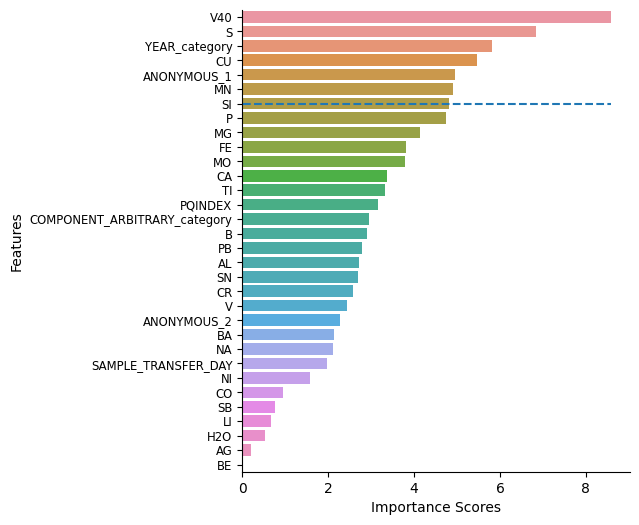

['V40', 'S', 'YEAR_category', 'CU', 'ANONYMOUS_1', 'MN']


In [42]:
plt.figure(figsize = (5, 6), dpi = 100)
FRUFS_model.feature_importance()
print(FRUFS_CatBoostRegressor_var)

# ['V40', 'S', 'YEAR_category', 'CU', 'ANONYMOUS_1', 'MN', 'SI']

In [64]:
Rdata_train4 = Rdata_train3.drop(['Y_LABEL'], axis = 1)

Progress bar: 100%|██████████| 32/32 [00:07<00:00,  4.10it/s]


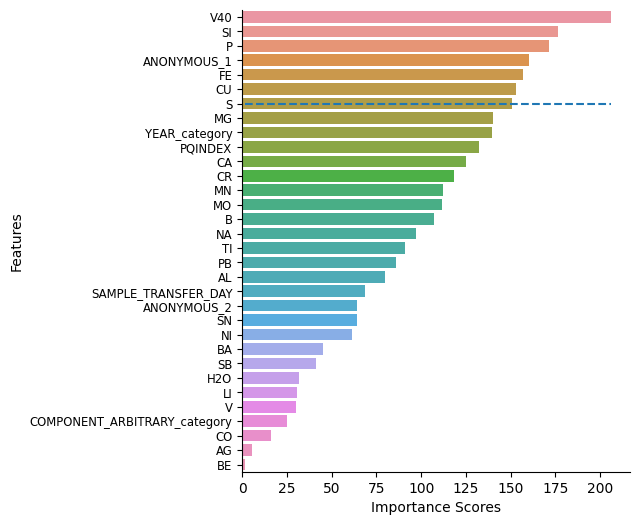

['V40', 'SI', 'P', 'ANONYMOUS_1', 'FE', 'CU']


In [65]:
FRUFS_model = FRUFS(model_r = LGBMRegressor(random_state = 39), k = 6, n_jobs = -1, verbose = False, random_state = 39)
Rdata_train4_FRUFS = FRUFS_model.fit_transform(Rdata_train4.loc[:, :])
FRUFS_LGBMRegressor_var = list(Rdata_train4_FRUFS.columns)

plt.figure(figsize = (5, 6), dpi = 100)
FRUFS_model.feature_importance()
print(FRUFS_LGBMRegressor_var)

# ['V40', 'S', 'YEAR_category', 'CU', 'ANONYMOUS_1', 'MN', 'SI']

# 6. permutation feature importance

In [43]:
!pip install eli5

     |████████████████████████████████| 216 kB 4.0 MB/s eta 0:00:01
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107728 sha256=f78e6167ca2e20c1cfe2daf1ed2c0caaa9eed097b0860a1848d5a57dec7a2dec
  Stored in directory: /home/studio-lab-user/.cache/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


In [44]:
import eli5
from eli5.sklearn import PermutationImportance

In [55]:
Rdata_train3 = Rdata_train2.drop(['CD', 'K'], axis = 1)
Rdata_train3.shape

(14095, 33)

In [56]:
Rdata_train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ANONYMOUS_1                   14095 non-null  int64  
 1   SAMPLE_TRANSFER_DAY           14095 non-null  int64  
 2   ANONYMOUS_2                   14095 non-null  int64  
 3   AG                            14095 non-null  int64  
 4   AL                            14095 non-null  int64  
 5   B                             14095 non-null  int64  
 6   BA                            14095 non-null  int64  
 7   BE                            14095 non-null  int64  
 8   CA                            14095 non-null  int64  
 9   CO                            14095 non-null  int64  
 10  CR                            14095 non-null  int64  
 11  CU                            14095 non-null  int64  
 12  FE                            14095 non-null  int64  
 13  H

In [57]:
X_train = Rdata_train3.drop(['Y_LABEL'], axis = 1)
y_train = Rdata_train3['Y_LABEL']

In [58]:
model = CatBoostClassifier(random_state = 39).fit(X_train, y_train)

Learning rate set to 0.031885
0:	learn: 0.6494757	total: 65.5ms	remaining: 1m 5s
1:	learn: 0.6088172	total: 86.5ms	remaining: 43.2s
2:	learn: 0.5722353	total: 97ms	remaining: 32.2s
3:	learn: 0.5394683	total: 116ms	remaining: 28.9s
4:	learn: 0.5096436	total: 135ms	remaining: 26.9s
5:	learn: 0.4820114	total: 144ms	remaining: 23.9s
6:	learn: 0.4568129	total: 161ms	remaining: 22.8s
7:	learn: 0.4341542	total: 176ms	remaining: 21.8s
8:	learn: 0.4136939	total: 199ms	remaining: 21.9s
9:	learn: 0.3935040	total: 219ms	remaining: 21.7s
10:	learn: 0.3764757	total: 234ms	remaining: 21s
11:	learn: 0.3608112	total: 246ms	remaining: 20.3s
12:	learn: 0.3456177	total: 277ms	remaining: 21s
13:	learn: 0.3323232	total: 290ms	remaining: 20.5s
14:	learn: 0.3201127	total: 310ms	remaining: 20.3s
15:	learn: 0.3084937	total: 321ms	remaining: 19.8s
16:	learn: 0.2979334	total: 341ms	remaining: 19.7s
17:	learn: 0.2886254	total: 358ms	remaining: 19.6s
18:	learn: 0.2796299	total: 376ms	remaining: 19.4s
19:	learn: 0.2

In [59]:
perm = PermutationImportance(model, random_state = 39).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top = 100)

# AL, ANONYMOUS_1, CA, YEAR_category, B, FE, P, S, BA, V40

Weight,Feature
0.0857 ± 0.0029,AL
0.0109 ± 0.0013,ANONYMOUS_1
0.0092 ± 0.0003,CA
0.0069 ± 0.0008,YEAR_category
0.0051 ± 0.0005,B
0.0049 ± 0.0006,FE
0.0046 ± 0.0009,P
0.0037 ± 0.0006,S
0.0032 ± 0.0003,CU
0.0031 ± 0.0007,BA


In [60]:
model = LGBMClassifier(random_state = 39).fit(X_train, y_train)

perm = PermutationImportance(model, random_state = 39).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist(), top = 100)

# AL, ANONYMOUS_1, CA, YEAR_category, B, FE, P, S, BA, V40

Weight,Feature
0.0928 ± 0.0018,AL
0.0168 ± 0.0022,ANONYMOUS_1
0.0151 ± 0.0016,CA
0.0119 ± 0.0013,YEAR_category
0.0106 ± 0.0014,B
0.0073 ± 0.0009,P
0.0059 ± 0.0006,V40
0.0052 ± 0.0008,FE
0.0050 ± 0.0009,BA
0.0047 ± 0.0005,S
